<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/Friends_Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO**:

*   Better text augmentation
*   Add speaker as input2
*   Add the annotation as an output target
*   Ensemble model


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import random

print(tf.__version__)

seed = 51

tf.random.set_seed(seed)
random.seed(seed)

2.3.0


# Load and prep data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving friends_test.json to friends_test.json
Saving friends_dev.json to friends_dev.json
Saving friends_train.json to friends_train.json


# Albert

In [3]:
!pip install sentencepiece -q

     |████████████████████████████████| 1.1MB 8.5MB/s 


In [4]:
!wget -nv https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

2020-08-07 11:37:56 URL:https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py [16775/16775] -> "tokenization.py" [1]


In [5]:
from numpy import array

def albert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
      text = tokenizer.tokenize(text)
      text = text[:max_seq_length-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      input_sequence = text
      pad_len = max_seq_length - len(input_sequence)
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_seq_length
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)

    return [array(all_tokens), array(all_masks), array(all_segments)]

In [6]:
def prep_data(df):
    
    texts = []
    labels = []

    for _,row in df.iterrows():
      texts.append(row.utterance)
      labels.append(row.label)

    return albert_encode(texts), array(labels)

# Competition prediction task



> In the competition they only predict samples with joy, sadness, anger, and neutral. All others are discarded. 



In [7]:
import pandas as pd

allowed_emotions = ['joy', 'sadness', 'anger', 'neutral']

df = pd.read_json('friends_train.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

df = pd.read_json('friends_dev.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

val_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])

df = pd.read_json('friends_test.json')
utterances = []
emotions = []
for _, row in df.iterrows():
  for i in range(len(df.columns)):
    if row[i] is not None and row[i]['emotion'] in allowed_emotions:
      speaker = row[i]['speaker']
      utterance = row[i]['utterance'].replace('\x92', '`')
      utterances.append(utterance)
      # utterances.append(speaker + ' says: ' + utterance)
      emotions.append(row[i]['emotion'])

test_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion'])
test_df['emotion'].value_counts()

neutral    1287
joy         304
anger       161
sadness      85
Name: emotion, dtype: int64

Reduce the number of neutral samples:

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
# lets combine + shuffle train and val and then split again.
combined_df = pd.concat([train_df, val_df])
combined_df = combined_df.sample(frac=1).reset_index(False)
# indices = []
# for idx, row in combined_df.iterrows():
#   if row.emotion == 'neutral':
#     indices.append(idx)

# n = 5243-1400
# combined_df.drop(indices[:n], axis='index', inplace=True)
# train_df, val_df = train_test_split(combined_df, test_size=0.2, shuffle=True, 
#                                     stratify=combined_df['emotion'], random_state=seed)
# print(train_df['emotion'].value_counts())

# Text augmentation

In [9]:
!pip install nlpaug -q
import nlpaug.augmenter.word as naw

     |████████████████████████████████| 102kB 4.2MB/s 


In [10]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [11]:
text = train_df.head(1)['utterance'].values[0]
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)
augmented_text2 = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)
print(augmented_text2)

Original:
also I was the point person on my company`s transition from the KL-5 to GR-6 system.
Augmented Text:
also I was the dot person on my ship's company ` s transition from the KL - 5 to GR - 6 system .
also I was the point person on my company ` s transition from the KL - little phoebe to GR - half a dozen organisation .


In [12]:
aug = naw.SynonymAug(aug_src='wordnet')
utterances = []
emotions = []
for _,row in train_df.iterrows():
    utterances.append(row.utterance)
    emotions.append(row.emotion)
    if row.emotion == 'sadness' or row.emotion == 'anger':  # add one augmented sample for anger
      augmented = aug.augment(utterance)
      utterances.append(augmented)
      emotions.append(row.emotion)
    if row.emotion == 'sadness':  # add two for sadness
      augmented = aug.augment(utterance)
      utterances.append(augmented)
      emotions.append(row.emotion)

train_df = pd.DataFrame(list(zip(utterances, emotions)), 
               columns =['utterance', 'emotion']) 

In [13]:
max_len = -1
for _,row in combined_df.iterrows():
  length = len(row.utterance)
  if length > max_len:
    max_len = length

max_len

241

In [14]:
# create the labels as integers
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
train_df.drop(['emotion'], axis='columns', inplace=True)

val_df['label'] = labelEncoder.transform(val_df['emotion'].values)
val_df.drop(['emotion'], axis='columns', inplace=True)

test_df['label'] = labelEncoder.transform(test_df['emotion'].values)
test_df.drop(['emotion'], axis='columns', inplace=True)

num_classes=len(labelEncoder.classes_)
labelEncoder.classes_

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

# Model

In [15]:
max_seq_length = max_len
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
albert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/1",
                              trainable=False)
pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])

In [16]:
import tokenization
import sentencepiece

In [17]:
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = tokenization.FullSentencePieceTokenizer(sp_model_file)

In [18]:
x_train, y_train = prep_data(train_df)
x_val, y_val = prep_data(val_df)
x_test, y_test = prep_data(test_df)

y_true = y_test

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [19]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

m = Dense(16, activation='relu')(pooled_output)
out = Dense(num_classes, activation='softmax')(m)
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[out])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 241)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 241)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 241)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [20]:
import tensorflow_addons as tfa

total = 161+304+1287+85
weight_for_0 = (1 / 161)*(total)/4.0 
weight_for_1 = (1 / 304)*(total)/4.0
weight_for_2 = (1 / 1287)*(total)/4.0
weight_for_3 = (1 / 85)*(total)/4.0
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

In [21]:
f1_score = tfa.metrics.F1Score(num_classes, average='micro', name='f1')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=[f1_score])

In [22]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    print('Using learning_rate = ' + str(self.model.optimizer.learning_rate.numpy()))

# Train

In [23]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint( filepath, monitor='val_loss', verbose=0, 
                                        save_best_only=True, save_weights_only=True, 
                                        mode='auto')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                      verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    # class_weight = class_weight
                    )

Epoch 1/100
254/254 [==============================] - 86s 337ms/step - loss: 1.0193 - f1: 0.6145 - val_loss: 0.9688 - val_f1: 0.6491
Epoch 2/100
254/254 [==============================] - 85s 335ms/step - loss: 0.8890 - f1: 0.6658 - val_loss: 0.9547 - val_f1: 0.6675
Epoch 3/100
254/254 [==============================] - 85s 334ms/step - loss: 0.8625 - f1: 0.6749 - val_loss: 0.9708 - val_f1: 0.6557
Epoch 4/100
254/254 [==============================] - 85s 334ms/step - loss: 0.8447 - f1: 0.6702 - val_loss: 0.9608 - val_f1: 0.6439
Epoch 5/100
254/254 [==============================] - 85s 334ms/step - loss: 0.8280 - f1: 0.6876 - val_loss: 0.9665 - val_f1: 0.6426
Epoch 6/100
254/254 [==============================] - 85s 334ms/step - loss: 0.8228 - f1: 0.6887 - val_loss: 1.0057 - val_f1: 0.6610
Epoch 7/100
254/254 [==============================] - 85s 334ms/step - loss: 0.8068 - f1: 0.6899 - val_loss: 0.9626 - val_f1: 0.6531
Epoch 8/100
254/254 [==============================] - 85s 334

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


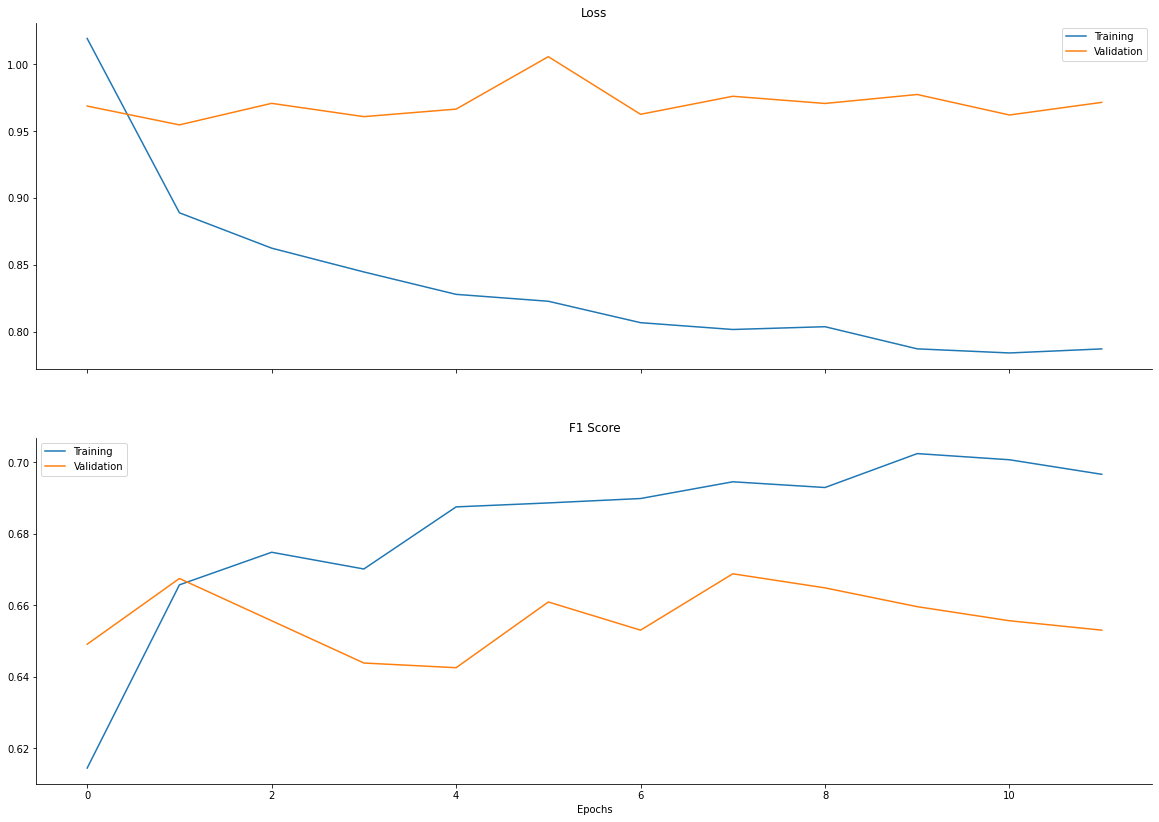

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Fine tune

In [25]:
model.load_weights(filepath)
model.get_layer(name='keras_layer').trainable = True
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 241)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 241)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 241)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss='categorical_crossentropy', 
              metrics=[f1_score])

In [27]:
history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_val, y_val), callbacks=[mc, es],
                    # class_weight = class_weight
                    )

Epoch 1/100
254/254 [==============================] - 233s 917ms/step - loss: 0.8023 - f1: 0.6963 - val_loss: 0.9148 - val_f1: 0.6951
Epoch 2/100
254/254 [==============================] - 232s 915ms/step - loss: 0.7340 - f1: 0.7260 - val_loss: 0.8705 - val_f1: 0.7109
Epoch 3/100
254/254 [==============================] - 232s 915ms/step - loss: 0.7005 - f1: 0.7365 - val_loss: 0.8537 - val_f1: 0.7188
Epoch 4/100
254/254 [==============================] - 232s 914ms/step - loss: 0.6751 - f1: 0.7439 - val_loss: 0.8636 - val_f1: 0.7083
Epoch 5/100
254/254 [==============================] - 232s 914ms/step - loss: 0.6487 - f1: 0.7499 - val_loss: 0.8369 - val_f1: 0.7135
Epoch 6/100
254/254 [==============================] - 232s 914ms/step - loss: 0.6222 - f1: 0.7597 - val_loss: 0.8686 - val_f1: 0.7201
Epoch 7/100
254/254 [==============================] - 232s 914ms/step - loss: 0.6006 - f1: 0.7658 - val_loss: 0.8407 - val_f1: 0.7254
Epoch 8/100
254/254 [==============================] - 

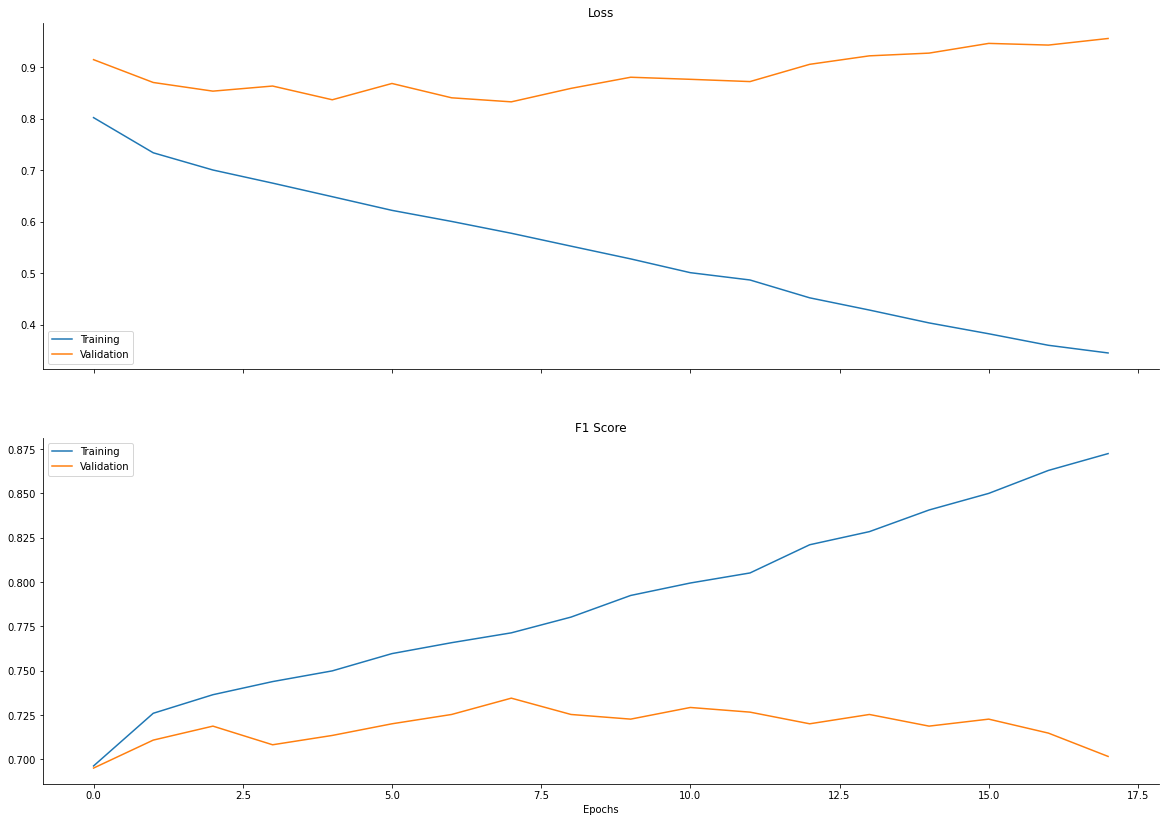

In [28]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['f1'], label='Training')
ax2.plot(history['val_f1'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('F1 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [29]:
model.load_weights(filepath)
model.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 17s 299ms/step - loss: 0.6735 - f1: 0.7741


[0.673490047454834, 0.7740882039070129]

* Adam with fine-tuning                        : **loss: 0.1261 - f1: 0.7763**
* with original split                          : loss: 0.1281 - f1: 0.7670
* original split with no Dense layer           : loss: 0.6591 - f1: 0.7735
* Adam with original split, no SFCE            : loss: 0.6968 - f1: 0.7703
* with text augmentation                       : **loss: 0.6735 - f1: 0.7741**
* ensemble model                               :


In [30]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)

Check the F1 score for each class

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labelEncoder.classes_))

              precision    recall  f1-score   support

       anger       0.48      0.25      0.33       161
         joy       0.56      0.55      0.55       304
     neutral       0.84      0.94      0.89      1287
     sadness       0.00      0.00      0.00        85

    accuracy                           0.77      1837
   macro avg       0.47      0.44      0.44      1837
weighted avg       0.72      0.77      0.74      1837



Text augmentation helped with anger.

```
                precision    recall  f1-score   support

       anger       0.48      0.25      0.33       161
         joy       0.56      0.55      0.55       304
     neutral       0.84      0.94      0.89      1287
     sadness       0.00      0.00      0.00        85

    accuracy                           0.77      1837
   macro avg       0.47      0.44      0.44      1837
weighted avg       0.72      0.77      0.74      1837
```

